In [1]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight



In [2]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')

In [7]:
def import_data(which_path=2):
    if which_path==1:
        images_directory = path/'train_images'
    else: 
        images_directory = path/'train_images2'
    cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
    cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)
    return (cb_training, cb_validation)


def base_set_up(filename):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=2)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

In [4]:
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up()

Found 30000 files belonging to 2 classes.
Using 24000 files for training.


2022-03-21 14:17:54.391638: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [5]:
s_training, s_validation  = import_data(1)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


2022-03-20 21:28:53.115185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


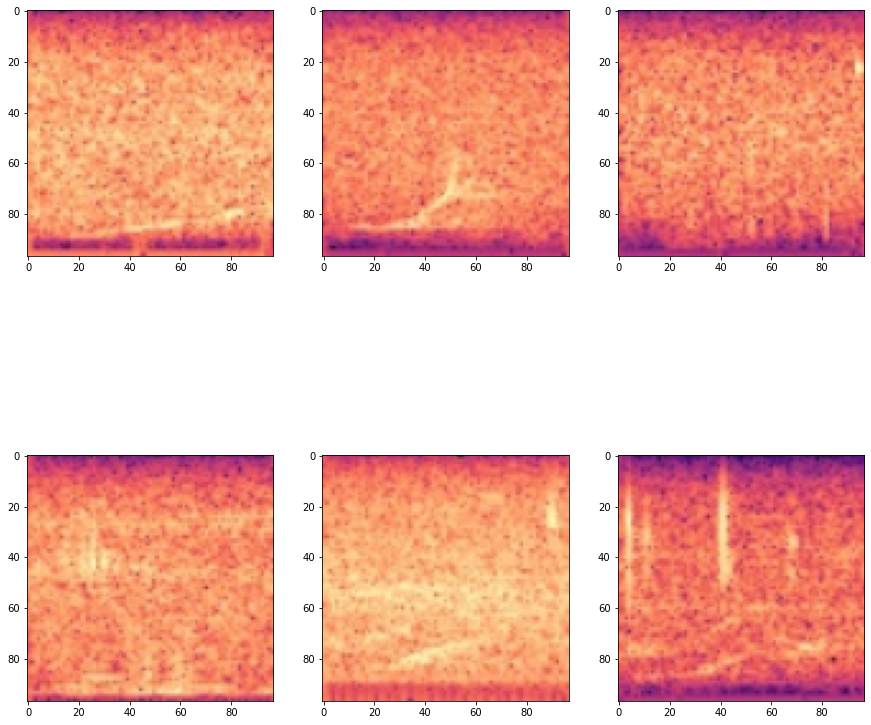

In [10]:
fig, axes = plt.subplots(2,3, figsize=(15,15))
for images, labels in cb_validation.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

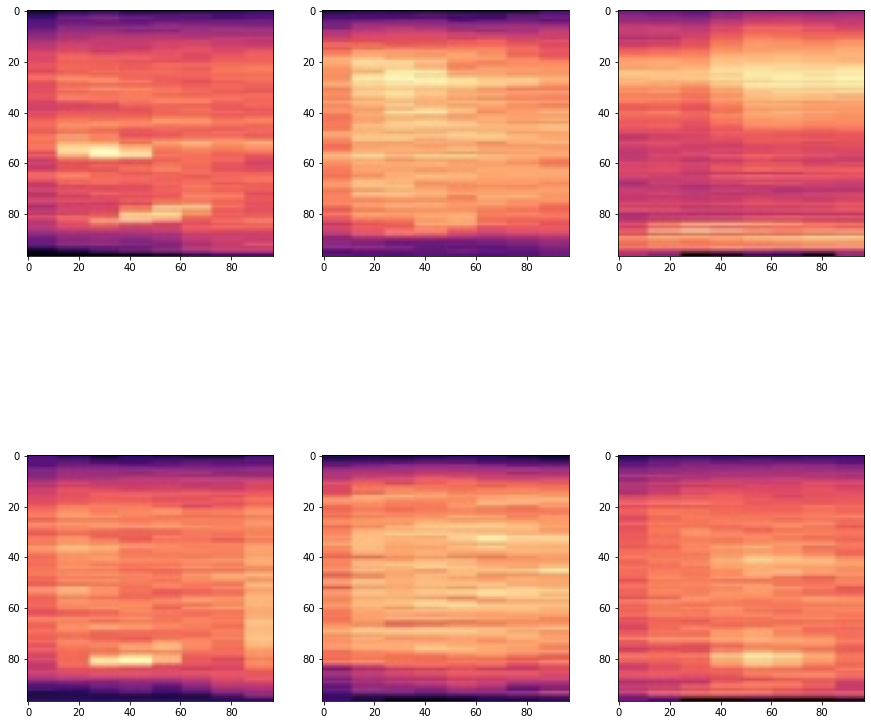

In [11]:
fig, axes = plt.subplots(2,3, figsize=(15,15))
for images, labels in s_validation.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

In [13]:
checkpoint = ModelCheckpoint('transfer_vgg19_default_learn_rate.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# Experiment 1: Different spectrograms VGG

In [8]:
# Early stopping 

model = None
keras.backend.clear_session()


filename = 'vgg19-cb.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)


predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)

history = model.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 17232s 23s/step - loss: 2.7791 - tp: 3721.0000 - fp: 6023.0000 - tn: 12349.0000 - fn: 1907.0000 - accuracy: 0.6696 - precision: 0.3819 - recall: 0.6612 - auc: 0.7072 - prc: 0.3862 - val_loss: 1.0319 - val_tp: 1228.0000 - val_fp: 1209.0000 - val_tn: 3392.0000 - val_fn: 171.0000 - val_accuracy: 0.7700 - val_precision: 0.5039 - val_recall: 0.8778 - val_auc: 0.8699 - val_prc: 0.6084

Epoch 00001: val_accuracy improved from -inf to 0.77000, saving model to vgg19-cb.h5
Epoch 2/10
750/750 [==============================] - 22036s 29s/step - loss: 1.5195 - tp: 4100.0000 - fp: 4940.0000 - tn: 13432.0000 - fn: 1528.0000 - accuracy: 0.7305 - precision: 0.4535 - recall: 0.7285 - auc: 0.7856 - prc: 0.4835 - val_loss: 0.6437 - val_tp: 1209.0000 - val_fp: 958.0000 - val_tn: 3643.0000 - val_fn: 190.000

In [10]:
# Nevermind, I just ran two of these that are the same because im a genius. 
# Rerunning, again
model = None
keras.backend.clear_session()


filename = 'vgg19-s.h5'
s_training, s_validation  = import_data(1)
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)


predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)



history = model.fit(s_training, epochs=10,validation_data=s_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 666s 885ms/step - loss: 3.1720 - tp: 3846.0000 - fp: 6283.0000 - tn: 12089.0000 - fn: 1782.0000 - accuracy: 0.6640 - precision: 0.3797 - recall: 0.6834 - auc: 0.7048 - prc: 0.3823 - val_loss: 0.6420 - val_tp: 990.0000 - val_fp: 514.0000 - val_tn: 4087.0000 - val_fn: 409.0000 - val_accuracy: 0.8462 - val_precision: 0.6582 - val_recall: 0.7076 - val_auc: 0.8758 - val_prc: 0.6883

Epoch 00001: val_accuracy improved from -inf to 0.84617, saving model to vgg19-s.h5
Epoch 2/10
750/750 [==============================] - 738s 984ms/step - loss: 1.4676 - tp: 4168.0000 - fp: 4962.0000 - tn: 13410.0000 - fn: 1460.0000 - accuracy: 0.7324 - precision: 0.4565 - recall: 0.7406 - auc: 0.7922 - prc: 0.4888 - val_loss: 0.4350 - val_tp: 1063.0000 - val_fp: 518.0000 - val_tn: 4083.0000 - val_fn: 336.0000 -

# Experiment 2: Different spectrograms CNN
Must be redone because I didn't zero out the existing models. 


In [12]:
cnn = None
keras.backend.clear_session()


filename = 'cnn-cb.h5'
cb_training, s_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)



cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())

cnn.add(layers.Dense(20, activation='relu'))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(100, activation='relu'))

cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)



history = cnn.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 79s 99ms/step - loss: 0.4565 - tp: 4783.0000 - fp: 4939.0000 - tn: 13433.0000 - fn: 845.0000 - accuracy: 0.7590 - precision: 0.4920 - recall: 0.8499 - auc: 0.8619 - prc: 0.6169 - val_loss: 0.3249 - val_tp: 1271.0000 - val_fp: 868.0000 - val_tn: 3733.0000 - val_fn: 128.0000 - val_accuracy: 0.8340 - val_precision: 0.5942 - val_recall: 0.9085 - val_auc: 0.9301 - val_prc: 0.7806

Epoch 00001: val_accuracy improved from -inf to 0.83400, saving model to cnn-cb.h5
Epoch 2/10
750/750 [==============================] - 73s 97ms/step - loss: 0.2852 - tp: 5326.0000 - fp: 3248.0000 - tn: 15124.0000 - fn: 302.0000 - accuracy: 0.8521 - precision: 0.6212 - recall: 0.9463 - auc: 0.9433 - prc: 0.7978 - val_loss: 0.2675 - val_tp: 1285.0000 - val_fp: 646.0000 - val_tn: 3955.0000 - val_fn: 114.0000 - val_a

In [13]:
cnn = None
keras.backend.clear_session()


filename = 'cnn-s.h5'
s_training, s_validation  = import_data(1)
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)



cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())

cnn.add(layers.Dense(20, activation='relu'))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(100, activation='relu'))

cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)



history = cnn.fit(s_training, epochs=10,validation_data=s_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 84s 103ms/step - loss: 0.4160 - tp: 4977.0000 - fp: 4573.0000 - tn: 13799.0000 - fn: 651.0000 - accuracy: 0.7823 - precision: 0.5212 - recall: 0.8843 - auc: 0.8856 - prc: 0.6604 - val_loss: 0.3572 - val_tp: 1331.0000 - val_fp: 1061.0000 - val_tn: 3540.0000 - val_fn: 68.0000 - val_accuracy: 0.8118 - val_precision: 0.5564 - val_recall: 0.9514 - val_auc: 0.9278 - val_prc: 0.7596

Epoch 00001: val_accuracy improved from -inf to 0.81183, saving model to cnn-s.h5
Epoch 2/10
750/750 [==============================] - 75s 100ms/step - loss: 0.2896 - tp: 5236.0000 - fp: 3104.0000 - tn: 15268.0000 - fn: 392.0000 - accuracy: 0.8543 - precision: 0.6278 - recall: 0.9303 - auc: 0.9436 - prc: 0.8070 - val_loss: 0.2605 - val_tp: 1285.0000 - val_fp: 619.0000 - val_tn: 3982.0000 - val_fn: 114.0000 - val_

# Continue Training
## Summary So Far:
I've ran models for 10 epochs on CNN, Resnet, and VGG, using both types of spectgrograms in order to see if there is a major difference.  
I expect there will be, because while the data in the spectgrograms is the same, the format of the image is not - we're constrained it to 97 by 97, and the graininer spectrogram has a lot more in the vertical direction, which is not being saved. 

### Transfer Learning 
#### Resnet50 
##### CB spectrogram(clearer), 
ran for 10, we can continue
```
Epoch 10/10
750/750 [==============================] - 638s 851ms/step - loss: 0.2534 - tp: 5182.0000 - fp: 2469.0000 - tn: 15903.0000 - fn: 446.0000 - accuracy: 0.8785 - precision: 0.6773 - recall: 0.9208 - auc: 0.9587 - prc: 0.8687 - val_loss: 0.2461 - val_tp: 1215.0000 - val_fp: 475.0000 - val_tn: 4126.0000 - val_fn: 184.0000 - val_accuracy: 0.8902 - val_precision: 0.7189 - val_recall: 0.8685 - val_auc: 0.9538 - val_prc: 0.8607

Epoch 00010: val_accuracy improved from 0.87783 to 0.89017, saving model to resnet-cb.h5

```

##### S spectrogram
Ran for 6
```
Epoch 00005: val_accuracy did not improve from 0.87467
Epoch 6/10
750/750 [==============================] - 456s 609ms/step - loss: 0.2905 - tp: 5132.0000 - fp: 2872.0000 - tn: 15500.0000 - fn: 496.0000 - accuracy: 0.8597 - precision: 0.6412 - recall: 0.9119 - auc: 0.9458 - prc: 0.8264 - val_loss: 0.2731 - val_tp: 1228.0000 - val_fp: 584.0000 - val_tn: 4017.0000 - val_fn: 171.0000 - val_accuracy: 0.8742 - val_precision: 0.6777 - val_recall: 0.8778 - val_auc: 0.9480 - val_prc: 0.8425

Epoch 00006: val_accuracy did not improve from 0.87467
Epoch 00006: early stopping
```

#### VGG 19
##### CB spectrogram, 
ran for 6, early stopped  
Recall: .89 
```
Epoch 6/10
750/750 [==============================] - 1101s 1s/step - loss: 0.6169 - tp: 4451.0000 - fp: 4259.0000 - tn: 14113.0000 - fn: 1177.0000 - accuracy: 0.7735 - precision: 0.5110 - recall: 0.7909 - auc: 0.8515 - prc: 0.5839 - val_loss: 0.4139 - val_tp: 1249.0000 - val_fp: 952.0000 - val_tn: 3649.0000 - val_fn: 150.0000 - val_accuracy: 0.8163 - val_precision: 0.5675 - val_recall: 0.8928 - val_auc: 0.9069 - val_prc: 0.7142

Epoch 00006: val_accuracy did not improve from 0.81833
Epoch 00006: early stopping
```
##### S spectrogram
Early stopped, 5  
Recall: .82
```
Epoch 5/10
750/750 [==============================] - 967s 1s/step - loss: 0.6033 - tp: 4494.0000 - fp: 4320.0000 - tn: 14052.0000 - fn: 1134.0000 - accuracy: 0.7728 - precision: 0.5099 - recall: 0.7985 - auc: 0.8540 - prc: 0.6079 - val_loss: 0.3237 - val_tp: 1157.0000 - val_fp: 639.0000 - val_tn: 3962.0000 - val_fn: 242.0000 - val_accuracy: 0.8532 - val_precision: 0.6442 - val_recall: 0.8270 - val_auc: 0.9205 - val_prc: 0.7661

Epoch 00005: val_accuracy did not improve from 0.86050
Epoch 00005: early stopping
```

### Home Grown CNN 
##### CB Spectrogram
Early stopped 8
```
Epoch 00007: val_accuracy did not improve from 0.90717
Epoch 8/10
750/750 [==============================] - 71s 95ms/step - loss: 0.1967 - tp: 5351.0000 - fp: 2060.0000 - tn: 16312.0000 - fn: 277.0000 - accuracy: 0.9026 - precision: 0.7220 - recall: 0.9508 - auc: 0.9728 - prc: 0.9063 - val_loss: 0.2577 - val_tp: 1322.0000 - val_fp: 598.0000 - val_tn: 4003.0000 - val_fn: 77.0000 - val_accuracy: 0.8875 - val_precision: 0.6885 - val_recall: 0.9450 - val_auc: 0.9667 - val_prc: 0.8896

Epoch 00008: val_accuracy did not improve from 0.90717
Epoch 00008: early stopping
```

##### S spectrogram 
Early stopped at 5 
````
Epoch 00004: val_accuracy did not improve from 0.88433
Epoch 5/10
750/750 [==============================] - 77s 103ms/step - loss: 0.2315 - tp: 5341.0000 - fp: 2501.0000 - tn: 15871.0000 - fn: 287.0000 - accuracy: 0.8838 - precision: 0.6811 - recall: 0.9490 - auc: 0.9622 - prc: 0.8693 - val_loss: 0.2523 - val_tp: 1319.0000 - val_fp: 646.0000 - val_tn: 3955.0000 - val_fn: 80.0000 - val_accuracy: 0.8790 - val_precision: 0.6712 - val_recall: 0.9428 - val_auc: 0.9615 - val_prc: 0.8701

Epoch 00005: val_accuracy did not improve from 0.88433
Epoch 00005: early stopping
````

## Conclusion 
It looks like CNN has a similar reliablity to transfer learning for this problem.  
I will try adjusting the CNN, and see if we can get a higher accuracy( and recall), and I will keep training the models that stopped at 10 epochs and see if we get better values 

### The Spectrograms
The stopping seems to take place a little later and at slightly higher values for the CB spectrogram than the S spectrogram across the board.   
I will stick to CB spectrogram - its clearer for me, and it seems to be producing slightly higher results, as expected. 

# Continue